In [47]:
%reload_ext autoreload
%autoreload 2

# Install procgen tools if needed
try:
  import procgen_tools
except ImportError:
  get_ipython().run_line_magic(magic_name='pip', line='install git+https://github.com/ulissemini/procgen-tools')

In [48]:
# Download data and create directory structure

import os, sys
from pathlib import Path
from procgen_tools.utils import setup

setup() # create directory structure and download data

# path this notebook expects to be in
if 'experiments' not in os.getcwd():
    Path('experiments').mkdir(exist_ok=True)
    os.chdir('experiments')

Already downloaded https://nerdsniper.net/mats/episode_data.tgz
Already downloaded https://nerdsniper.net/mats/data.tgz
Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [49]:
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output
from ipywidgets import *
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

# NOTE: this is Monte's RL hooking code (and other stuff will be added in the future)
# Install normally with: pip install circrl
import circrl.module_hook as cmh
import procgen_tools.models as models
from patch_utils import *
from procgen_tools.vfield import *
from procgen import ProcgenGym3Env

In [50]:
# Check whether we're in jupyter
try:
    get_ipython()
    in_jupyter = True
except NameError:
    in_jupyter = False

In [51]:
# Load model
rand_region = 5
policy = models.load_policy(path_prefix + f'trained_models/maze_I/model_rand_region_{rand_region}.pth', 15, t.device('cpu'))

In [52]:
label = 'embedder.block2.res1.resadd_out'
interesting_coeffs = np.linspace(-2/3,2/3,10) 
hook = cmh.ModuleHook(policy)

# RUN ABOVE here

In [ ]:
@interact
def interactive_patching(seed=IntSlider(min=0, max=20, step=1, value=0), coeff=FloatSlider(min=-3, max=3, step=0.1, value=-1)):
    fig, _, _ = plot_patched_vfield(seed, coeff, label, hook)
    plt.show()

In [ ]:
value_seed = 0
values_tup = cheese_diff_values(value_seed, label, hook), value_seed

for seed in range(10):  
    run_seed(seed, hook, [-1], values_tup=values_tup)


In [ ]:
seeds = range(10)
coeffs = [-2, -1, -0.5, 0.5, 1, 2]
for seed, coeff in tqdm(list(itertools.product(seeds, coeffs))):
    fig, _ = plot_patched_vfield(seed, coeff)
    fig.savefig(f"../figures/patched_vfield_seed{seed}_coeff{coeff}.png", dpi=300)
    plt.clf()
    plt.close()

In [ ]:
@interact 
def custom_values(seed=IntSlider(min=0, max=100, step=1, value=0)):
    global v_env # TODO this seems to not play nicely if you change original seed? Other mazes are negligibly affected
    v_env = get_custom_venv_pair(seed=seed)


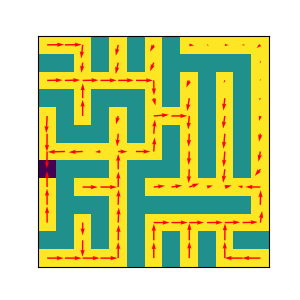

In [58]:
""" Edit a maze and see how that changes the vector field representing the action probabilities. """

%matplotlib inline
%matplotlib widget

fig, ax = plt.subplots(1,1, figsize=(3,3))
output = Output()

# @interact 
# def custom_vfield(seed=IntSlider(min=0, max=100, step=1, value=0)):
seed = 0
single_venv = create_venv(num=1, start_level=seed, num_levels=1)

# We want to update ax whenever the maze is edited
def update_plot(venv_ax, venv: ProcgenGym3Env, policy: t.nn.Module):
    # Clear the existing plot
    with output:
        venv_ax.clear()
        
        # Remove ticks 
        ax.set_xticks([])
        ax.set_yticks([])
        
        vfield = vector_field(venv, policy)
        plot_vf(vfield, ax=venv_ax)
        # Update the existing figure in place 
        clear_output(wait=True)
        display(fig)

update_plot(ax, single_venv, policy)

# Then make a callback which updates the render in-place when the maze is edited
editors = maze.venv_editors(single_venv, check_on_dist=False, env_nums=range(1), callback=lambda _: update_plot(ax, single_venv, policy))

# Display the maze editor and the plot in an HBox
display(VBox(editors + [output]))

In [ ]:
# Assumes a fixed venv, hook, values, and label
@interact
def interactive_patching(seed=IntSlider(min=0, max=20, step=1, value=0), coeff=FloatSlider(min=-3, max=3, step=0.05, value=-1)):
    values = values_from_venv(v_env, hook, label)
    fig, _, _ = plot_patched_vfield(seed, coeff, label, hook, values=values)
    plt.show()


In [ ]:
values = values_from_venv(v_env, hook, label)
target_env = get_custom_venv_pair(seed=0)


In [ ]:
fig, _, _ = plot_patched_vfield(0, -1, label, hook, values=values, venv=target_env)
plt.show()


In [ ]:
fig, _, _ = plot_patched_vfield(0, -1, label, hook, values=values, venv=v_env)


In [ ]:
for seed in range(50):
    run_seed(seed, hook, interesting_coeffs)


In [ ]:
values = np.zeros_like(cheese_diff_values(0, label, hook))
seeds = slice(int(10e5),int(10e5+100))

# Iterate over range specified by slice
for seed in range(seeds.start, seeds.stop):
    # Make values be rolling average of values from seeds
    values = (seed-seeds.start)/(seed-seeds.start+1)*values + cheese_diff_values(seed, label, hook)/(seed-seeds.start+1)

# Assumes a fixed venv, hook, values, and label
@interact
def interactive_patching(seed=IntSlider(min=0, max=20, step=1, value=0), coeff=FloatSlider(min=-10, max=10, step=0.1, value=-1)):
    fig, _, _ = plot_patched_vfield(seed, coeff, label, hook, values=values)
    plt.show()


In [ ]:
values = t.rand_like(t.from_numpy(cheese_diff_values(0, label, hook))).numpy()
for seed in range(20):
    run_seed(seed, hook, [-1], values_tup=(values, 'garbage'))


In [ ]:
labels = list(hook.values_by_label.keys()) # TODO this dict was changing in size during the loop, but why?
# Interactive function to run all labels
@interact
def run_all_labels(seed=IntSlider(min=0, max=20, step=1, value=0), coeff=FloatSlider(min=-3, max=3, step=0.1, value=-1), label=labels):
    fig, _, _ = plot_patched_vfield(seed, coeff, label, hook)
    plt.show()
